### Parte A
#### Pregunta 1:
Tenemos el siguiente sistema adjunto:
$$
\dot{ \left( \begin{array}{c} p_1 \\ p_2 \end{array} \right) } =
 - \left( \begin{array}{cc} -Cm_a - p_1 (M+C) & + p_2 N \zeta (t)  \\
                        -Cm_c + p_1 A \zeta(t-d) & + p_2 ( -(M+C) - A \zeta(t-d)) \end{array} \right)
$$

Con las siguientes condiciones de transversalidad
$$
p_1(t_f) = p_2(t_f) = 0; ~~ p_0 = 1
$$

Y la siguiente caracterización del control óptimo:
$$
C^* = \{ \begin{array}{cc} 0 & \ x_a(m_a+p_1) + x_c(m_a + p_2) < 0 \\
                           1 &\ x_a(m_a+p_1) + x_c(m_a + p_2) > 0  \end{array}
$$
Con $ x_a(t) = CA(t) $ y $x_c(t) = CC(t)$

In [2]:
#Pregunta 2
import numpy as np
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
import matplotlib.pyplot as plt
plt.style.use('dark_background')

m_a = 2e-2
m_c = 5e-3

def control_optimo(xa, xc, p, t):
    p1 = p[0]; p2 = p[1]
    condicion = xa*(m_a + p1) + xc*(m_c + p2)
    if condicion > 0:
        return 1
    else:
        return 0
    

In [7]:
#P3
A = 0.5; N = 0.85; M = 0.35; c = 12; t_f = 12; d = 4; zeta = lambda t: 1 + np.sin(2*np.pi*t/c)

discretizacion = 10**3
#Hay que definir la edo para (t, pyx)
def edo_asociada(t, xyp):
    xa, xc, p1, p2 = xyp
    dx_a = A*zeta(t-d)*xc - ( M + control_optimo(xa, xc, [p1, p2], t) )*xa
    dx_c = -A*zeta(t-d)*xc - (M + control_optimo(xa, xc, [p1, p2], t) )*xc + N*zeta(t)*xa
    dp_1 = - ( - control_optimo(xa, xc, [p1,p2], t) * m_a 
              - p1 * ( M + control_optimo(xa, xc, [p1,p2], t) ) + p2 * N * zeta(t) )
    dp_2 = - ( - control_optimo(xa, xc, [p1,p2], t) * m_c + p1 * A * zeta(t-d) 
             + p2 * ( -( M + control_optimo(xa, xc, [p1,p2], t) ) - A * zeta(t-d) ) )
    return [dx_a, dx_c, dp_1, dp_2]

def sistema_dinamico(cond_iniciales, discretizacion = discretizacion):
    """
    cond_iniciales: es un arreglo de condiciones iniciales para CA, CC, p1 y p2: 
    [CA(0), CC(0), p1(0), p2(0)]
    """
    intervalo = np.linspace(0, t_f, num=discretizacion)
    solucion = solve_ivp(edo_asociada, [0, t_f], cond_iniciales, t_eval = intervalo )
    return solucion

In [8]:
#Pregunta 4
x_ini = np.array( [3000, 1000] )
def auxiliar(p_inicial):
    inicial = np.concatenate( [x_ini, p_inicial] )
    solucion = solve_ivp(edo_asociada, [0, t_f], inicial, t_eval = [t_f] )
    xyp_final_sp = solucion.y
    p_final_sp = xyp_final_sp[-2:]
    p_final_lab = [0, 0]
    mse2 = ((p_final_sp - p_final_lab)**2).sum()
    return mse2

#cons = ({"type" : "eq", "fun" : auxiliar})
p_inicio = np.ones(2)
sols_1 = minimize( auxiliar, p_inicio )
sols_1

  message: Desired error not necessarily achieved due to precision loss.
  success: False
   status: 2
      fun: 206531178915869.88
        x: [-5.487e+01 -1.315e+01]
      nit: 2
      jac: [ 3.017e+13 -1.573e+14]
 hess_inv: [[-1.220e-15 -6.812e-16]
            [-3.524e-16 -1.967e-16]]
     nfev: 21
     njev: 3

In [9]:
p_inicial = sols_1.x
inicial = np.concatenate( [x_ini, p_inicial] )
intervalo = np.linspace(0, t_f, num=discretizacion)
solucion = solve_ivp(edo_asociada, [0, t_f], inicial, t_eval = intervalo )

In [5]:
xa_sol = solucion.y[0]
xc_sol = solucion.y[1]
p1_sol = solucion.y[2]
p2_sol = solucion.y[3]

In [6]:
print(solucion.y[2, -1])
print(solucion.y[3, -1])

-18.29373276612952
-14.861233348047476


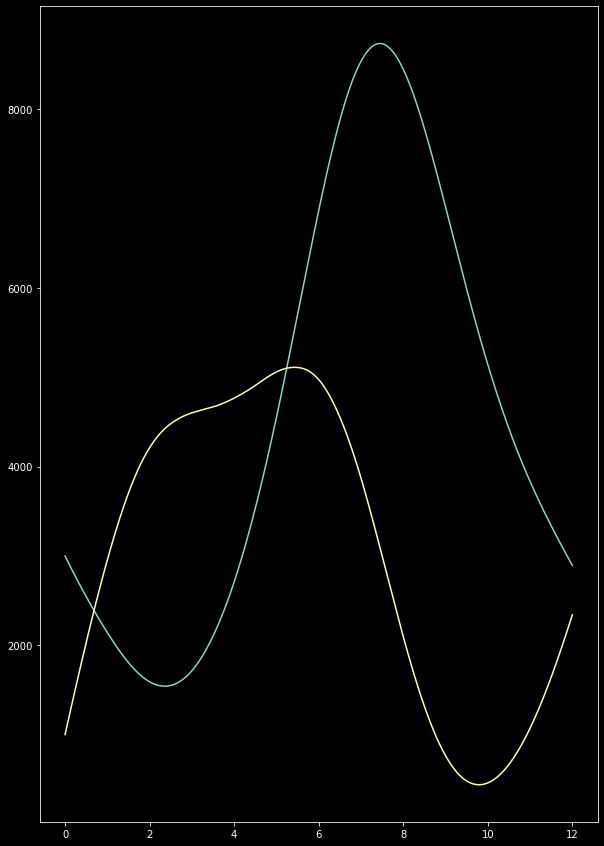

In [7]:
fig = plt.figure(figsize = (15,10))
plt.plot(intervalo, xa_sol)
plt.plot(intervalo, xc_sol)
plt.show()

In [8]:
control = np.zeros(len(intervalo))
for i in range(len(control)):
    control[i] = control_optimo(xa_sol[i], xc_sol[i], [p1_sol[i], p2_sol[i]], i)

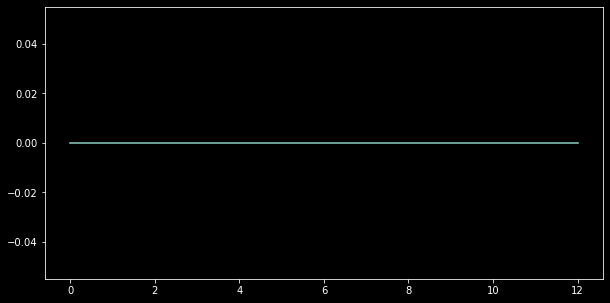

In [9]:
fig = plt.figure(figsize = (10,5))
plt.plot(intervalo, control)
plt.show()

### Parte B

#### Pregunta 7

Para el Hamiltoniano tenemos
$$
H(x, u, \partial_x V(t, x) ) = (xu)^2 + \partial_x V(t, x)(-xu) 
$$
Por lo tanto el control óptimo es:
$$
u = \frac{\partial_x V(t, x)}{2x}
$$
Esto nos entrega las siguientes ecuaciones de HJB:
$$
\partial_t V(t, x) = \frac{(\partial_x V(t, x))^2}{4} 
$$
Obtenemos las siguientes EDOS para $a, b$ y $c$. Estas son las que implementaremos en Python
$$
\dot{a} = a^2; ~ \dot{b} = ab; ~ \dot{c} = \frac{b^2}{4}
$$
Lo que nos entrega las siguientes funciones para $a, b$ y $c$
$$
a(t) = -\frac{1}{t}; ~ b(t) = \frac{1}{t}; ~ c(t) = - \frac{1}{4t}
$$

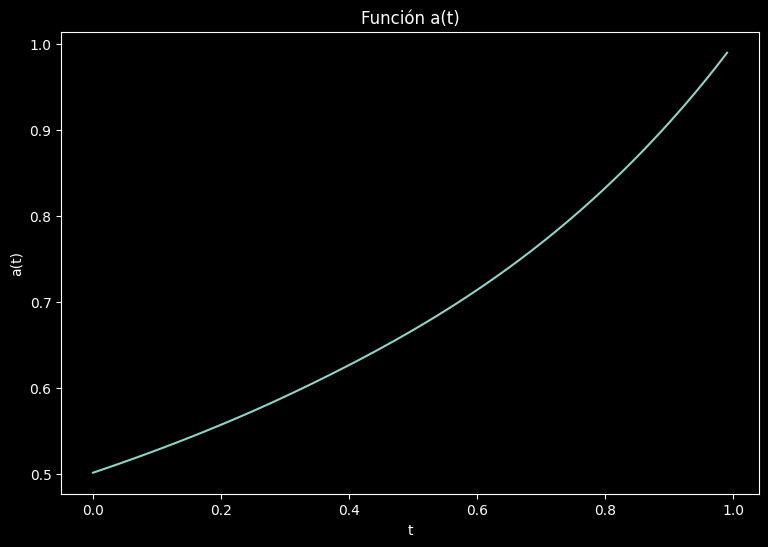

In [4]:
F_a = lambda t, s: s**2

t_eval = np.arange(0, 1, 10**-2)[::-1]
sol = solve_ivp(F_a, [1, 0], [1], t_eval=t_eval)

plt.figure(figsize = (9, 6))
plt.plot(sol.t, sol.y[0])
plt.xlabel('t')
plt.ylabel('a(t)')
plt.title("Función a(t)")
plt.show()
a = np.concatenate([[1], sol.y[0]])

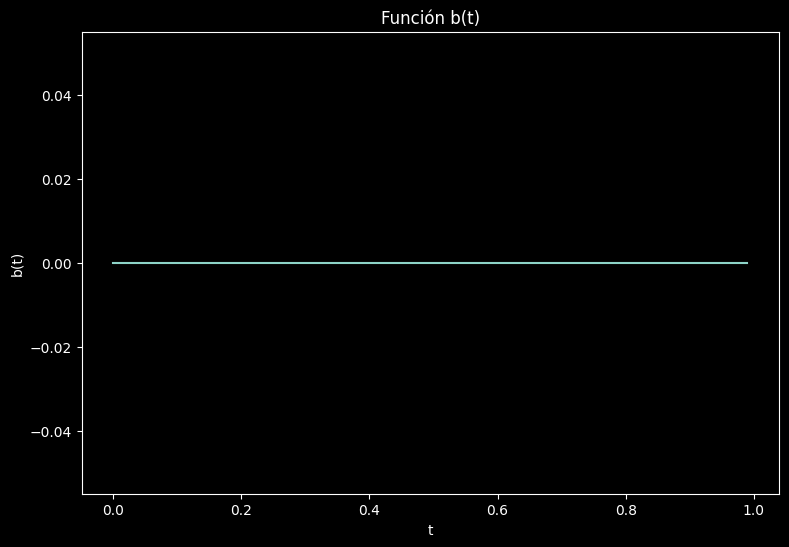

In [5]:
F_b = lambda t, s: a[-int(t*100) - 1]*s

t_eval = np.arange(0, 1, 10**-2)[::-1]
sol = solve_ivp(F_b, [1, 0], [0], t_eval=t_eval)

plt.figure(figsize = (9, 6))
plt.plot(sol.t, sol.y[0])
plt.xlabel('t')
plt.ylabel('b(t)')
plt.title("Función b(t)")
plt.show()
b = np.concatenate([[0], sol.y[0]])

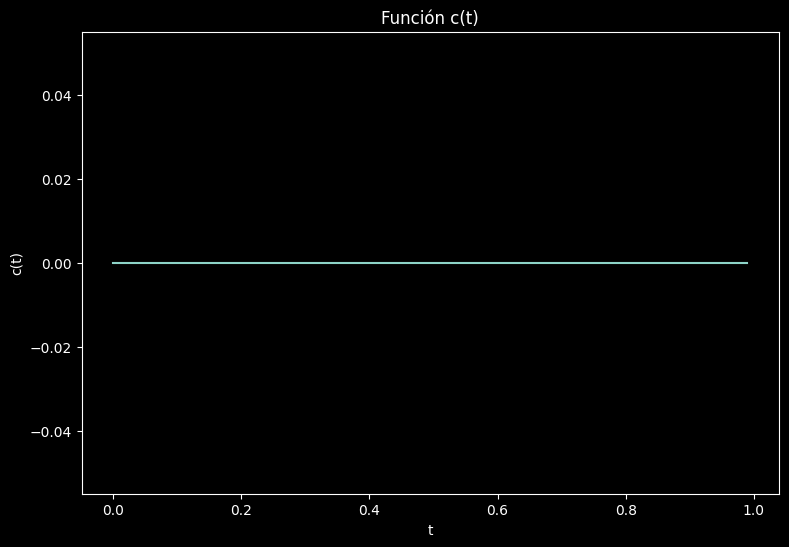

In [6]:
F_c = lambda t, s: (b[-int(t*100) - 1]**2)/4

t_eval = np.arange(0, 1, 10**-2)[::-1]
sol = solve_ivp(F_c, [1, 0], [0], t_eval=t_eval)

plt.figure(figsize = (9, 6))
plt.plot(sol.t, sol.y[0])
plt.xlabel('t')
plt.ylabel('c(t)')
plt.title("Función c(t)")
plt.show()

In [66]:
#Pregunta 8
def gamma(x, dx_V):
    if type(x) == function:
        u = lambda t: dx_V(t, x)/x(t)
    elif type(x) == np.ndarray:
        u = dx_V / x
    return u

dx_V = a[t]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [69]:
type(a)

numpy.ndarray